In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import calendar
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, visualize_prior, model_graph, traceplot, plot_gps_components, plot_elbo
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

# Outside Piecewise Linear w/ Partial pooling

In [12]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [13]:
groups = generate_groups_data_flat(y = data, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [4]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints = 4,
                  piecewise_out=True)

In [5]:
#m.prior_predictive_checks()
#visualize_prior(groups, m.prior_checks, 8)

In [6]:
m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 3.8877e+06


Sampling...


In [7]:
m.predict()

Sampling...


In [ ]:
# Check the ELBO convergence
#plot_elbo(m.trace_vi, 50000)

In [ ]:
# Visualize the GPs components
#plot_gps_components(series=4, groups=m.g, trace=m.trace_vi_samples)

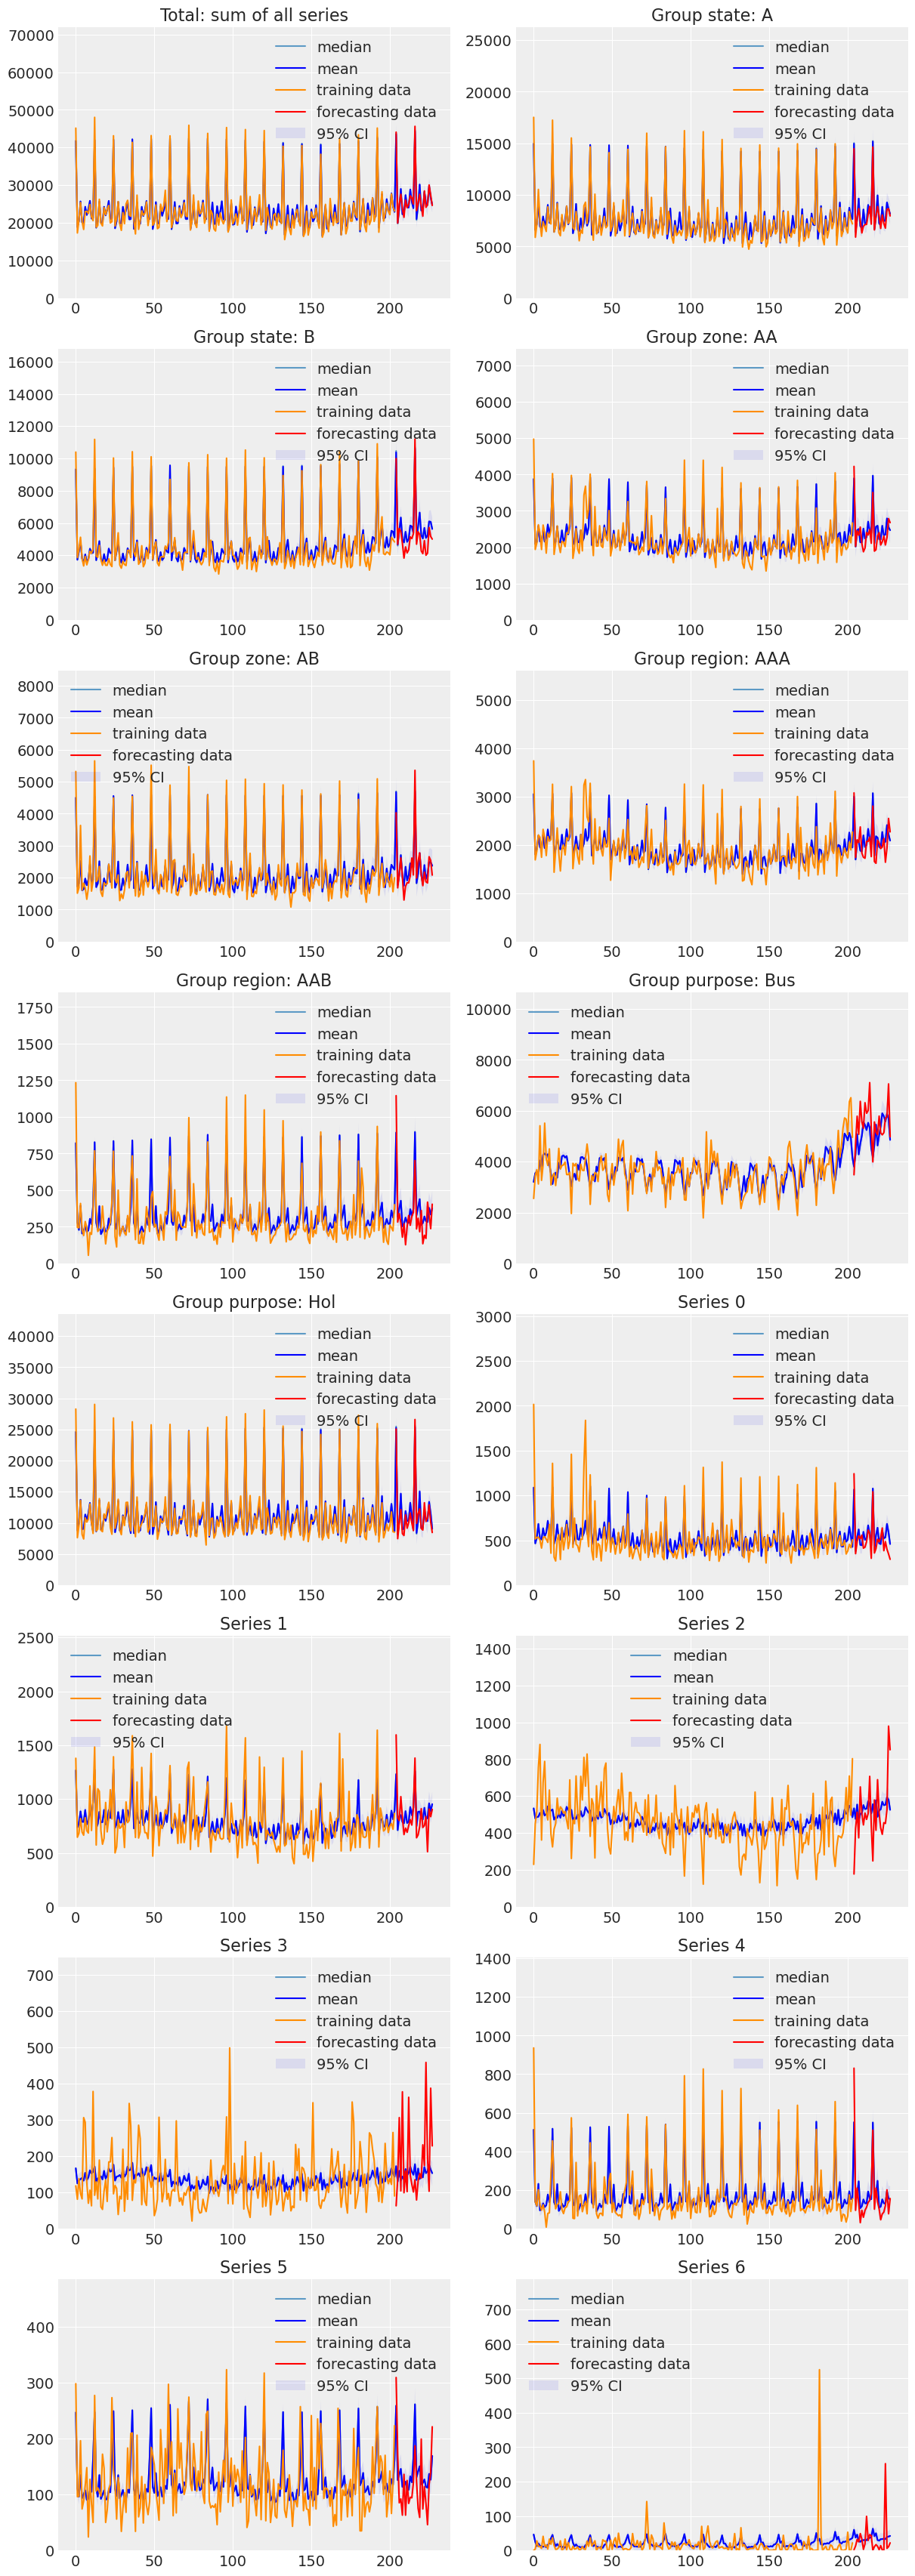

In [10]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [11]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

,bottom,total,state,zone,region,purpose,all
mase,1.082,0.621,1.438,1.15,1.055,0.881,1.075
rmse,44.941,1194.572,562.503,217.374,103.766,683.245,63.543
